In [1]:
#import neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rc('legend',markerscale=20)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
pd.set_option('display.max_columns', None,'display.max_rows', None)
import pyutilib.services
from importlib import reload
import os
import re
import numpy.random as nprd

os.makedirs('Saved_solutions',exist_ok=True)
os.makedirs('Saved_models',exist_ok=True)

Module_path = 'Modules'  # specify path to modules folder where baf, fopt, and are located, 
                            # change as needed for environment
import sys
sys.path.insert(0,Module_path)
import base_functions as baf
import Bolt_opt_functions as fopt
import analysis_functions as anf
import DynamicThermoOpt_functions as dyn

import time

In [2]:
reload(dyn)
# these dictionaries are treated as having global scope
control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'pickle_output':'plotpklfiles/Population_model_smallStart_B1em8_1em6step.pkl',
    'parallel_solve':False,# boolean True/False
    'worker_count': 5,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[1e-6], # list positive reals
    'delta_flux':[1], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.005], # list positive reals
    'swarm_size':10, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':800000,
    'max_iter':100000,
    'acceptable_tol':1e-6,
    'solver_tol':1e-7,
    'feasibility_check':False,
    'feasibility_as_input':False,
    'annealing_check':False,
    'hsllib':'/opt/coinhsl/lib/libcoinhsl.dylib' # may need to comment out
}

ode_system_dictionary={
    'dt':1e-6,
#     'nmax':4800000,
    'nmax':9000000,
    'stoichiometry_matrix':[],
    'metabolites_to_fix':['B:CYTOSOL'], # now only for fixing external metabolites (empty or biomass ends up as 0)
    'jump_tolerance':0.5,
    'stall_on_opt_jump':5,
#     'Opt_frequency':200000
    'Opt_frequency':1000
}

environment_dictionary={
    'metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'transport_reactions':['Uptake','Excretion'],
    'chemostat_type':[['Zero',{'Magnitude':1e-4}],['Zero',{'Magnitude':1e-6}]],
    'initial_environment_concentrations':[1.0e-4,1e-6], # molar
    'bath_volume':1.0,
    'glucose_diffusion_constant':600 # µm^2/sec
}


cell_dictionary={
    'model':'smallModel_lowK_altB.pkl',#'smallModel_highK.pkl',
    'previous_best_model_solution':"",
    'environment_energy_name':'x1_e:ENVIRONMENT',
    'energy_import_reaction_name':'Uptake',
    'environment_compartment_name':'ENVIRONMENT',
    'biomass_reaction':'Biomass',
#     'adaptation_constant':0.01,
    'initial_cell_density':1.0e-5,
    'birth_rate':1.0,
    'death_rate':0.008,
    'import_energy_metabolites':['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT'],
    'import_energy_reactions':['Uptake','Excretion'],
    'import_energy_michaelis_menten':[0.04*1e-3,0.04*1e-3], # m moles
    
    'vmax':3.033e-12, # mM glucose consumed per hour per 1 micron^3 cell 
    'cell_volume':1e-15, 
    'hyphae_volume':4e3, # microns^3
    'N_avogadro':6.022140857e+23
    
}

In [3]:
metaboliteTraceDf,metabolitesOPT,fluxTraceDf,fluxOPT,regulationOPT,timesOPT,cell_density_vec,loopTimes = dyn.ReadFromPickle(control_dictionary)

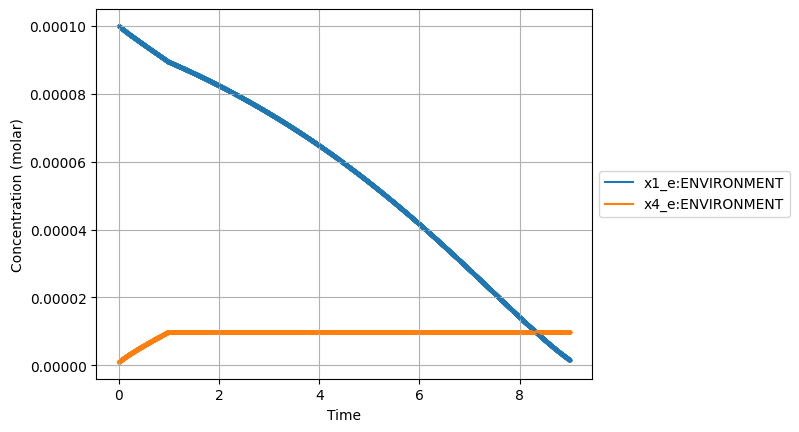

In [4]:
metaboliteSubset = ['x1_e:ENVIRONMENT','x4_e:ENVIRONMENT']

dyn.PlotConcentrationTraces(metaboliteTraceDf,metabolitesOPT,timesOPT,True,metaboliteSubset)

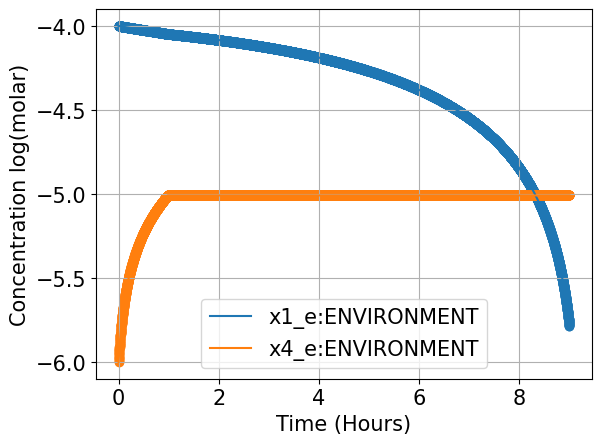

In [6]:
optConcMatrix=[]
ifPlotOpt = True

plt.rcParams.update({'font.size': 15})

for metab in metabolitesOPT[0].index.tolist():
            metabVec=[]
            if metab in metaboliteSubset:
                for i in range(len(metabolitesOPT)):
                    metabVec.append(metabolitesOPT[i].at[metab,'metabolite_conc'])

                optConcMatrix.append(metabVec)

metabNames=metaboliteSubset
if ifPlotOpt:
    for metab in metabNames:
        plt.plot(np.log10(metaboliteTraceDf[metab]),label=metab)
        plt.scatter(timesOPT,np.log10(optConcMatrix[metabNames.index(metab)]))
else:
    for metab in metabNames:
        plt.plot(metaboliteTraceDf[metab],label=metab)

#plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.legend()
plt.grid()
plt.xlabel('Time (Hours)')
plt.ylabel('Concentration log(molar)')
plt.show()

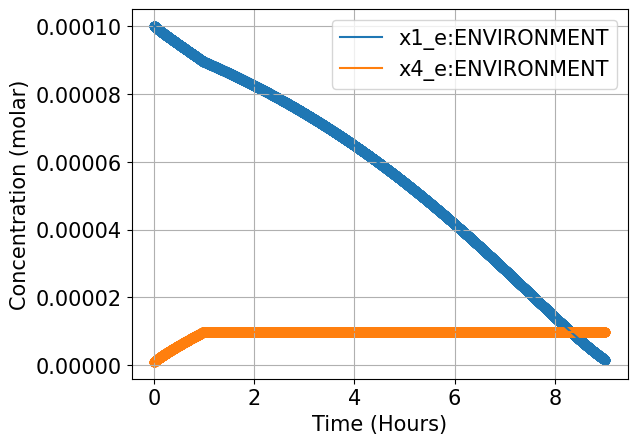

In [7]:
optConcMatrix=[]
ifPlotOpt = True

plt.rcParams.update({'font.size': 15})

for metab in metabolitesOPT[0].index.tolist():
            metabVec=[]
            if metab in metaboliteSubset:
                for i in range(len(metabolitesOPT)):
                    metabVec.append(metabolitesOPT[i].at[metab,'metabolite_conc'])

                optConcMatrix.append(metabVec)

metabNames=metaboliteSubset
if ifPlotOpt:
    for metab in metabNames:
        plt.plot(metaboliteTraceDf[metab],label=metab)
        plt.scatter(timesOPT,optConcMatrix[metabNames.index(metab)])
else:
    for metab in metabNames:
        plt.plot(metaboliteTraceDf[metab],label=metab)

#plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.legend()
plt.grid()
plt.xlabel('Time (Hours)')
plt.ylabel('Concentration (molar)')
plt.show()

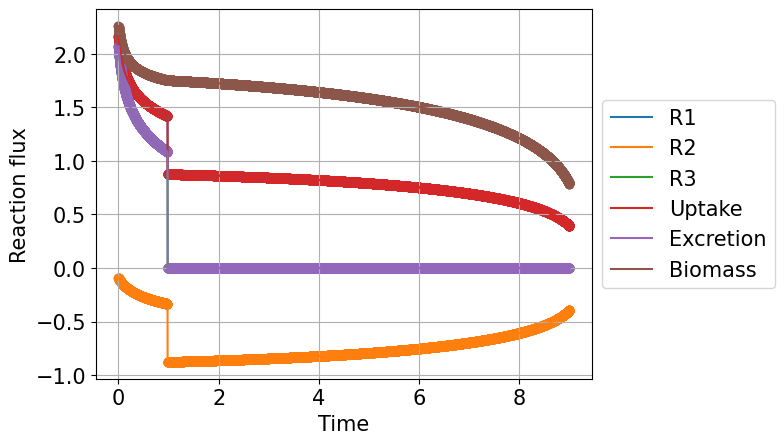

In [8]:
dyn.PlotFluxTraces(fluxTraceDf,fluxOPT,timesOPT,ifPlotOpt=True,reactionSubset=[],xlim=0)

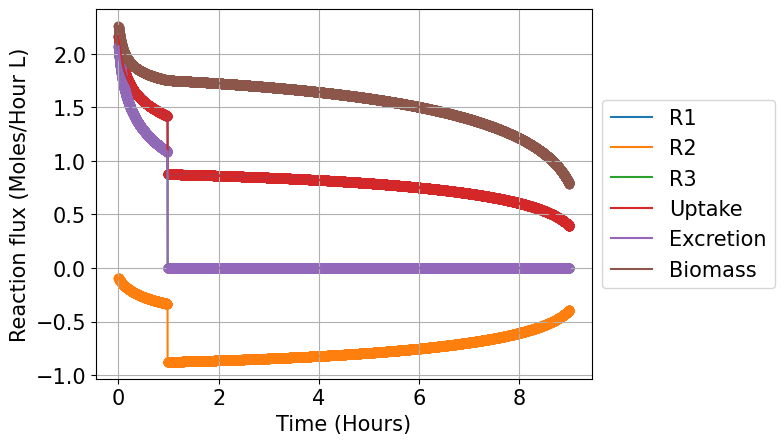

In [7]:
reactionOPT = fluxOPT
optFluxMatrix = []
ifPlotOpt = True
rxnNames=fluxTraceDf.columns.tolist()
for rxn in rxnNames:
    fluxVec=[]
    for i in range(len(reactionOPT)):
        fluxVec.append(reactionOPT[i]['Optimal Flux'][rxnNames.index(rxn)])

    optFluxMatrix.append(fluxVec)

if ifPlotOpt:
    for rxn in rxnNames:
        plt.plot(fluxTraceDf[rxn],label=rxn)
        plt.scatter(timesOPT,optFluxMatrix[rxnNames.index(rxn)])
else:
    for rxn in rxnNames:
        plt.plot(fluxTraceDf[rxn],label=rxn)


plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.grid()
plt.xlabel('Time (Hours)')
plt.ylabel('Reaction flux (Moles/Hour L)')
plt.show()





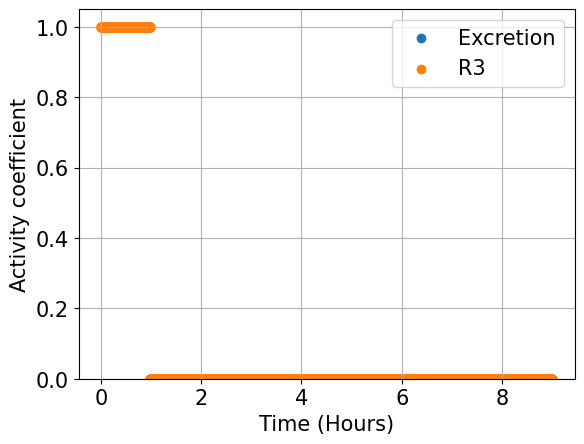

In [8]:
reactionSubset = ['Excretion','R3']

optRegulationMatrix=[]

delta = (timesOPT[-1]/(len(timesOPT)-1))/10 

if reactionSubset ==[]:

    for rxn in rxnNames:
        RegulationVec=[]
        for i in range(len(regulationOPT)):
            RegulationVec.append(regulationOPT[i][rxnNames.index(rxn)])

        optRegulationMatrix.append(RegulationVec)

    for rxn in rxnNames:
        timesRxn = [t + rxnNames.index(rxn)*delta for t in timesOPT]
        plt.scatter(timesRxn,optRegulationMatrix[rxnNames.index(rxn)],label=rxn)

else:

    for rxn in rxnNames:
        RegulationVec=[]
        if rxn in reactionSubset:
            for i in range(len(regulationOPT)):
                RegulationVec.append(regulationOPT[i][rxnNames.index(rxn)])

            optRegulationMatrix.append(RegulationVec)


    for rxn in reactionSubset:
        timesRxn = [t + reactionSubset.index(rxn)*delta for t in timesOPT]
        plt.scatter(timesRxn,optRegulationMatrix[reactionSubset.index(rxn)],label=rxn)
        

plt.legend()
plt.grid()
plt.xlabel('Time (Hours)')
plt.ylabel('Activity coefficient')
plt.ylim([0,1.05])
plt.show()

In [9]:
cell_volume = cell_dictionary['cell_volume']
gluc_gram_mole = 180.156
gramBiomass_to_cellcount =  5e-13
 
Vmax = 3.033e-12 # mM glucose consumed per hour per 1 micron^3 cell
Vmax = 1e-3*Vmax #convert to Molar
Km  = 0.04*1e-3

Text(0.5, 0, 'Time (Hours)')

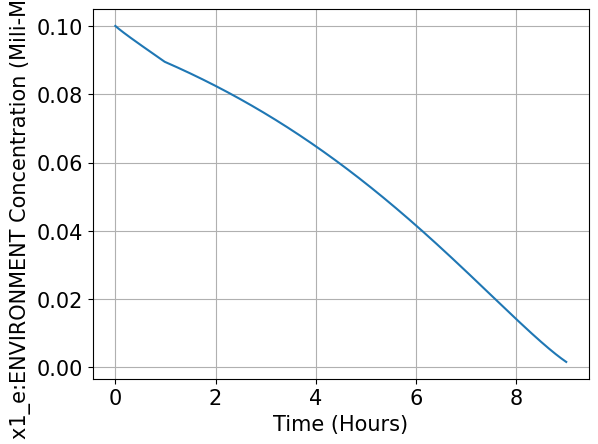

In [24]:
plt.plot(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'])
plt.ylabel('x1_e:ENVIRONMENT Concentration (Mili-Molar)')
plt.grid()
plt.xlabel('Time (Hours)')

In [41]:
print(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'].iloc[0])
print(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'].iloc[1000000])
print(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'].iloc[2000000])
print(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'].iloc[3000000])
print(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'].iloc[4000000])
print(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'].iloc[5000000])
print(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'].iloc[6000000])
print(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'].iloc[7000000])
print(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'].iloc[8000000])
print(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'].iloc[8999999])

0.09999999999999996
0.08940740625645582
0.08244273508364956
0.07427096155416174
0.06477273271158097
0.05387388125366556
0.041596393450841186
0.02815625030140301
0.014187012116584127
0.0016203888912271283


In [47]:
print(fluxTraceDf['Biomass'].iloc[0]*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)
print(fluxTraceDf['Biomass'].iloc[1000000]*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)
print(fluxTraceDf['Biomass'].iloc[2000000]*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)
print(fluxTraceDf['Biomass'].iloc[3000000]*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)
print(fluxTraceDf['Biomass'].iloc[4000000]*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)
print(fluxTraceDf['Biomass'].iloc[5000000]*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)
print(fluxTraceDf['Biomass'].iloc[6000000]*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)
print(fluxTraceDf['Biomass'].iloc[7000000]*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)
print(fluxTraceDf['Biomass'].iloc[8000000]*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)
print(fluxTraceDf['Biomass'].iloc[8999999]*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)

0.24435405781067054
0.18950319844919802
0.1864529321180231
0.18259900178536556
0.1776672275253564
0.17123649818893869
0.1625995152594476
0.15038394117270223
0.13110447676121148
0.08500067376800932


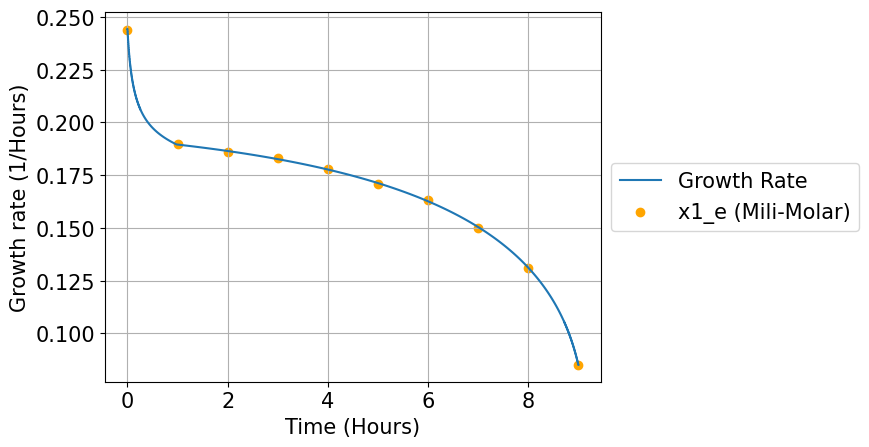

In [52]:
gluc_uptake = Vmax * metaboliteTraceDf['x1_e:ENVIRONMENT']/(Km + metaboliteTraceDf['x1_e:ENVIRONMENT'])
delta = (timesOPT[-1]/(len(timesOPT)-1))/10 #1e5
timesRxn = [t + reactionSubset.index(rxn)*delta for t in timesOPT]

plt.plot(fluxTraceDf['Biomass']*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount,label='Growth Rate')
plt.scatter([0,1,2,3,4,5,6,7,8,9],[0.244,0.190,0.186,0.183,0.178,0.171,0.163,0.150,0.131,0.085],color='orange',label='x1_e (Mili-Molar)')
plt.xlabel('Time (Hours)')
plt.grid()
plt.ylabel('Growth rate (1/Hours)')
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))

Text(0, 0.5, 'Growth rate (1/Hours)')

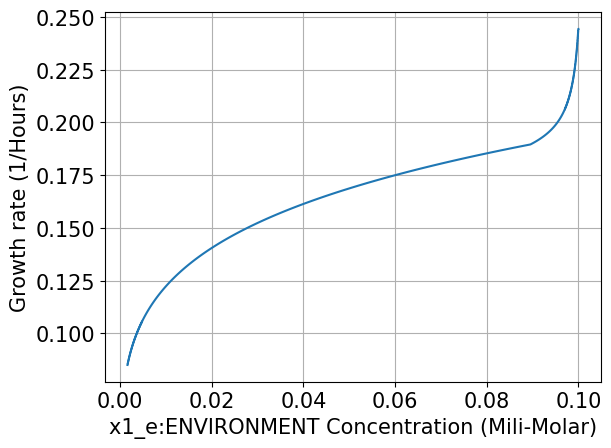

In [21]:
gluc_uptake = Vmax * metaboliteTraceDf['x1_e:ENVIRONMENT']/(Km + metaboliteTraceDf['x1_e:ENVIRONMENT'])
 
plt.plot(1e3*metaboliteTraceDf['x1_e:ENVIRONMENT'],fluxTraceDf['Biomass']*cell_volume*(0.3)*gluc_gram_mole/gramBiomass_to_cellcount)
plt.xlabel('x1_e:ENVIRONMENT Concentration (Mili-Molar)')
plt.grid()
plt.ylabel('Growth rate (1/Hours)')

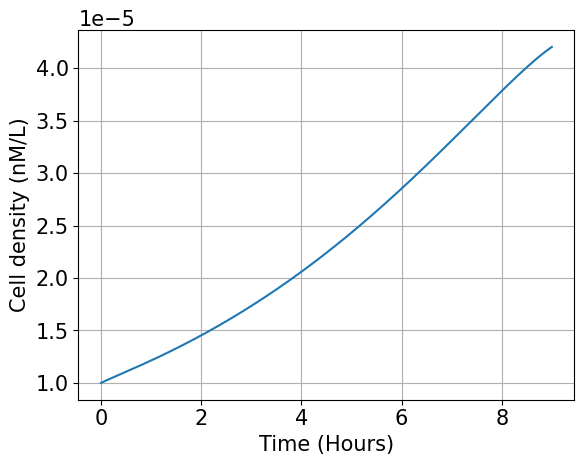

In [12]:
plt.plot(np.linspace(0,9,len(cell_density_vec)),cell_density_vec)
plt.grid()
plt.xlabel('Time (Hours)')
plt.ylabel('Cell density (nM/L)')
plt.show()

In [18]:

kf_list = []
kr_list = []

for i in range(len(fluxOPT)):
    fop = fluxOPT[i]
    kf = fop['kf'].values
    kr = fop['kr'].values
    kf_list.append(kf)
    kr_list.append(kr)

kf_dat = np.stack(kf_list)
kr_dat = np.stack(kr_list)

Text(0.5, 0, 'Time (Hours)')

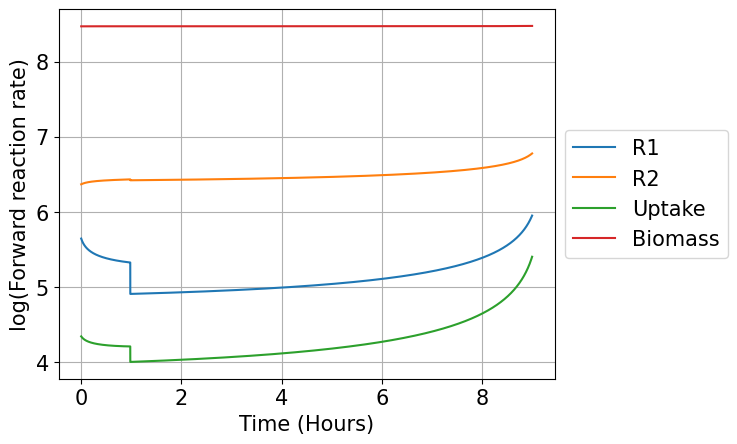

In [19]:
plt.plot(np.linspace(0,9,kf_dat.shape[0]),np.log10(kf_dat[:,np.array([0,1,3,5])]))
plt.grid()
plt.legend(['R1','R2','Uptake','Biomass'],loc='center left',bbox_to_anchor=(1,0.5))
plt.ylabel('log(Forward reaction rate)')
plt.xlabel('Time (Hours)')

Text(0.5, 0, 'Time (Hours)')

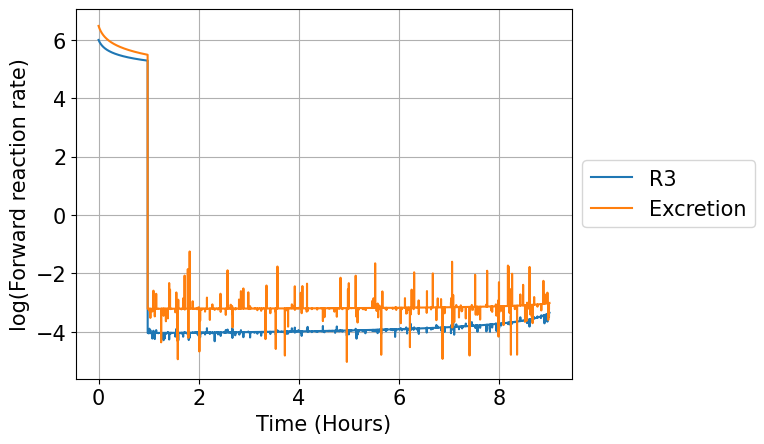

In [20]:
plt.plot(np.linspace(0,9,kf_dat.shape[0]),np.log10(kf_dat[:,np.array([2,4])]))
plt.grid()
plt.legend(['R3','Excretion'],loc='center left',bbox_to_anchor=(1,0.5))
plt.ylabel('log(Forward reaction rate)')
plt.xlabel('Time (Hours)')